### IMPORTS AND SETUP

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
import geopandas as gpd
import shapely.wkt
import os, warnings
import logging
import shap
import math
from scipy import spatial
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.stats import yeojohnson
from sklearn.ensemble import IsolationForest
import optuna
from optuna.samplers import TPESampler

logging.basicConfig(filename='warnings.log', level=logging.DEBUG)

def custom_warning_handler(message, category, filename, lineno, file=None, line=None):
    logging.debug(f'{category.__name__}: {message} in {filename}:{lineno}')

warnings.showwarning = custom_warning_handler

from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint
from shapely.ops import nearest_points
import rioxarray as rxr
import rasterio

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool

from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    HistGradientBoostingRegressor,
    GradientBoostingRegressor,
    VotingRegressor
)
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, KFold, cross_val_score, GroupKFold
from sklearn.linear_model import BayesianRidge, ElasticNet, Ridge, Lasso, LinearRegression, HuberRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, RationalQuadratic, ExpSineSquared
from sklearn.cluster import DBSCAN
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.base import clone, BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from joblib import dump, Parallel, delayed

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import sys

print("Python executable:", sys.executable)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

SHOW_PLOTS = True  # if you want to display some bar charts, etc.

Python executable: C:\workspace\python\ai-challenge-2025\.venv\Scripts\python.exe


### FEATURE TOGGLES

In [3]:
FEATURE_FLAGS = {
    # building coverage
    "building_cov_250m": True,
    "building_cov_500m": True,
    "building_cov_750m": True,
    "building_cov_std": True,  # Standard deviation of building coverage at different radii

    # distance to water and parks - with exponential decay transformations
    "distance_water": True,
    "distance_water_exp": True,  # Exponential decay of distance
    "distance_parks": True,
    "distance_parks_exp": True,  # Exponential decay of distance

    # street tree coverage - enhanced
    "street_tree_cov_250m": True, 
    "street_tree_cov_500m": True,
    "street_tree_cov_750m": True,

    # distance to subway - with transformations
    "dist_to_closest_subway_station": True,
    "dist_to_closest_subway_exp": True,  # Exponential decay of distance
    "dist_to_closest_cluster_centroid": True,
    "building_cluster_id": True,

    # raster-based features
    "lst_value": True,
    "ndvi_value": True,
    "ndbi_value": True,
    "ndwi_value": True,
    "evi_value": True,
    "mndwi_value": True,
    
    # Interaction features
    "bldg_lst_interaction": False,  # Building coverage × LST
    "ndvi_bldg_interaction": False,  # NDVI × Building coverage
    "water_park_interaction": False,  # Combined water and park effect
}

### HELPER FUNCTIONS

In [4]:
def exponential_decay(distance, scale=500):
    """Transform distance with exponential decay function"""
    return np.exp(-distance / scale)

def create_interaction_features(df):
    """Create interaction features that capture combined effects"""
    if "building_cov_500m" in df.columns and "lst_value" in df.columns:
        df["bldg_lst_interaction"] = df["building_cov_500m"] * df["lst_value"]
    
    if "building_cov_500m" in df.columns and "ndvi_value" in df.columns:
        df["ndvi_bldg_interaction"] = df["ndvi_value"] * (1 - df["building_cov_500m"])
    
    if "distance_water_exp" in df.columns and "distance_parks_exp" in df.columns:
        df["water_park_interaction"] = df["distance_water_exp"] * df["distance_parks_exp"]
    
    return df

def coverage_fraction(geom, polygon_gdf, radius=50):
    buffer_poly = geom.buffer(radius)
    clipped = gpd.clip(polygon_gdf, buffer_poly)
    area_polygons = clipped.geometry.area.sum()
    area_buffer = buffer_poly.area
    return area_polygons / area_buffer if area_buffer > 0 else 0

def coverage_std_multi_radius(geom, polygon_gdf, radii=[100, 250, 500, 750]):
    """Calculate standard deviation of coverage at different radii"""
    coverages = []
    for radius in radii:
        coverages.append(coverage_fraction(geom, polygon_gdf, radius))
    return np.std(coverages)

def building_coverage_fraction(geom, building_gdf, radius=50):
    return coverage_fraction(geom, building_gdf, radius)

def distance_to_polygons(geom, poly_gdf):
    dists = poly_gdf.geometry.distance(geom)
    return dists.min() if len(dists) > 0 else np.nan

def extract_raster_value(geom, raster, band_index=1, method="nearest"):
    """Extract value from raster at a point with fallback for edge cases"""
    try:
        x, y = geom.x, geom.y
        val = raster.sel(x=x, y=y, band=band_index, method=method).values
        return float(val)
    except (ValueError, IndexError) as e:
        # Fallback: Try to sample nearby values if exact point fails
        try:
            x, y = geom.x, geom.y
            buffer_size = 10  # Small buffer
            # Get average from small buffer area
            vals = []
            for dx in [-buffer_size, 0, buffer_size]:
                for dy in [-buffer_size, 0, buffer_size]:
                    try:
                        v = raster.sel(x=x+dx, y=y+dy, band=band_index, method=method).values
                        vals.append(float(v))
                    except:
                        pass
            if vals:
                return np.mean(vals)
            return np.nan
        except:
            return np.nan

def find_nearest_building_cluster(pt_geom, gdf_bldg):
    distances = gdf_bldg["centroid"].distance(pt_geom)
    if len(distances) == 0:
        return None
    idx_min = distances.idxmin()
    return gdf_bldg.loc[idx_min, "bldg_cluster"]

def nearest_cluster_centroid_label(pt_geom, cluster_centroids):
    px, py = pt_geom.x, pt_geom.y
    best_label = None
    best_dist = float("inf")
    for (c_label, (cx, cy)) in cluster_centroids:
        dist_ = math.hypot(cx - px, cy - py)
        if dist_ < best_dist:
            best_dist = dist_
            best_label = c_label
    return best_label

def euclidean_distance(x1, y1, x2, y2):
    return math.hypot(x2 - x1, y2 - y1)

def run_dbscan_on_buildings(gdf_buildings, eps_m=400, min_samples=10, N_LARGEST=3):
    if "centroid" not in gdf_buildings.columns:
        gdf_buildings["centroid"] = gdf_buildings.geometry.centroid
    
    coords_bldg = np.column_stack([gdf_buildings["centroid"].x, gdf_buildings["centroid"].y])
    
    db = DBSCAN(eps=eps_m, min_samples=min_samples).fit(coords_bldg)
    labels_bldg = db.labels_
    gdf_buildings["bldg_cluster"] = labels_bldg
    
    valid_mask = (labels_bldg >= 0)
    unique_labels, counts = np.unique(labels_bldg[valid_mask], return_counts=True)
    
    sorted_idx = np.argsort(-counts)
    sorted_labels = unique_labels[sorted_idx]
    sorted_counts = counts[sorted_idx]
    
    top_clusters = sorted_labels[:N_LARGEST]
    
    cluster_centroids = []
    for clabel in top_clusters:
        cl_mask = (gdf_buildings["bldg_cluster"] == clabel)
        cluster_coords = coords_bldg[cl_mask]
        if len(cluster_coords) > 0:
            mp = MultiPoint(cluster_coords)
            c_centroid = mp.centroid
            cluster_centroids.append((clabel, (c_centroid.x, c_centroid.y)))
    
    return gdf_buildings, cluster_centroids, top_clusters

def dist_to_closest_cluster_centroid_feature(geom, cluster_centroids):
    px, py = geom.x, geom.y
    dmin = float("inf")
    for (lbl, (cx, cy)) in cluster_centroids:
        d = euclidean_distance(px, py, cx, cy)
        if d < dmin:
            dmin = d
    return dmin

# Feature extraction function for both train and validation sets
def extract_features(gdf, features_dict=None):
    if features_dict is None:
        features_dict = {key: [] for key, val in FEATURE_FLAGS.items() if val}
    
    total_rows = len(gdf)
    print(f"Extracting features for {total_rows} points...")
    
    for i, row in gdf.iterrows():
        if i % 500 == 0:
            percent_done = (i / total_rows) * 100
            print(f"  -> {percent_done:.2f}% done")
        
        geom = row.geometry

        # Building coverage at multiple scales
        if FEATURE_FLAGS["building_cov_250m"]:
            b250 = building_coverage_fraction(geom, gdf_buildings, 250)
            features_dict["building_cov_250m"].append(b250)
            
        if FEATURE_FLAGS["building_cov_500m"]:
            b500 = building_coverage_fraction(geom, gdf_buildings, 500)
            features_dict["building_cov_500m"].append(b500)
            
        if FEATURE_FLAGS["building_cov_750m"]:
            b750 = building_coverage_fraction(geom, gdf_buildings, 750)
            features_dict["building_cov_750m"].append(b750)
            
        if FEATURE_FLAGS["building_cov_std"]:
            bstd = coverage_std_multi_radius(geom, gdf_buildings, [100, 250, 500, 750])
            features_dict["building_cov_std"].append(bstd)

        # Distance to water with exponential decay
        if FEATURE_FLAGS["distance_water"]:
            dist_w = distance_to_polygons(geom, gdf_water)
            features_dict["distance_water"].append(dist_w)
            
            if FEATURE_FLAGS["distance_water_exp"]:
                dist_w_exp = exponential_decay(dist_w, scale=500)
                features_dict["distance_water_exp"].append(dist_w_exp)

        # Distance to parks with exponential decay
        if FEATURE_FLAGS["distance_parks"]:
            dist_p = distance_to_polygons(geom, gdf_parks)
            features_dict["distance_parks"].append(dist_p)
            
            if FEATURE_FLAGS["distance_parks_exp"]:
                dist_p_exp = exponential_decay(dist_p, scale=500)
                features_dict["distance_parks_exp"].append(dist_p_exp)

        # Street tree coverage at multiple scales
        if FEATURE_FLAGS["street_tree_cov_250m"]:
            tree_250 = coverage_fraction(geom, gdf_trees_poly, 250)
            features_dict["street_tree_cov_250m"].append(tree_250)
            
        if FEATURE_FLAGS["street_tree_cov_500m"]:
            tree_500 = coverage_fraction(geom, gdf_trees_poly, 500)
            features_dict["street_tree_cov_500m"].append(tree_500)
            
        if FEATURE_FLAGS["street_tree_cov_750m"]:
            tree_750 = coverage_fraction(geom, gdf_trees_poly, 750)
            features_dict["street_tree_cov_750m"].append(tree_750)

        # Distance to subway
        if FEATURE_FLAGS["dist_to_closest_subway_station"]:
            dists_subway = gdf_stations.geometry.distance(geom)
            dist_sub = dists_subway.min() if len(dists_subway) > 0 else 0
            features_dict["dist_to_closest_subway_station"].append(dist_sub)
            
            if FEATURE_FLAGS["dist_to_closest_subway_exp"]:
                dist_sub_exp = exponential_decay(dist_sub, scale=800)
                features_dict["dist_to_closest_subway_exp"].append(dist_sub_exp)

        # Raster-based features
        if FEATURE_FLAGS["lst_value"]:
            lst_val = extract_raster_value(geom, lst_raster_2263, band_index=1)
            features_dict["lst_value"].append(lst_val)

        if FEATURE_FLAGS["ndvi_value"]:
            ndvi_val = extract_raster_value(geom, indices_raster_2263, band_index=1)
            features_dict["ndvi_value"].append(ndvi_val)

        if FEATURE_FLAGS["ndbi_value"]:
            ndbi_val = extract_raster_value(geom, indices_raster_2263, band_index=2)
            features_dict["ndbi_value"].append(ndbi_val)

        if FEATURE_FLAGS["ndwi_value"]:
            ndwi_val = extract_raster_value(geom, indices_raster_2263, band_index=3)
            features_dict["ndwi_value"].append(ndwi_val)

        if FEATURE_FLAGS["evi_value"]:
            evi_value = extract_raster_value(geom, indices_raster_2263, band_index=4)
            features_dict["evi_value"].append(evi_value)
            
        if FEATURE_FLAGS["mndwi_value"]:
            mndwi_value = extract_raster_value(geom, indices_raster_2263, band_index=5)
            features_dict["mndwi_value"].append(mndwi_value)

        # Building clusters
        if FEATURE_FLAGS["building_cluster_id"]:
            c_str = nearest_cluster_centroid_label(geom, cluster_centroids)
            if c_str is not None:
                c_str = f"N{c_str}"
            else:
                c_str = "other"
            features_dict["building_cluster_id"].append(c_str)
        
        if FEATURE_FLAGS["dist_to_closest_cluster_centroid"]:
            dmin = dist_to_closest_cluster_centroid_feature(geom, cluster_centroids)
            features_dict["dist_to_closest_cluster_centroid"].append(dmin)
            
    print("100.00% done")
    return features_dict

# Enhanced isolation forest for outlier detection
class OutlierDetector:
    def __init__(self, contamination=0.01, random_state=42):
        self.contamination = contamination
        self.random_state = random_state
        self.model = IsolationForest(
            contamination=contamination,
            random_state=random_state,
            n_estimators=200,
            max_samples='auto'
        )
        
    def fit_detect(self, X, y):
        # Combine features and target for detection
        data = np.column_stack([X, y.reshape(-1, 1)])
        self.model.fit(data)
        outlier_mask = self.model.predict(data) == -1
        return outlier_mask

# Spatial cross-validation
class SpatialKFold:
    def __init__(self, n_splits=5, random_state=None):
        self.n_splits = n_splits
        self.random_state = random_state
        
    def split(self, X, y, coordinates):
        """
        Split data spatially using KMeans clustering of coordinates
        
        Parameters:
        -----------
        X : array-like
            Features
        y : array-like
            Target
        coordinates : array-like
            Spatial coordinates (x, y) of each sample
            
        Yields:
        -------
        train_index, test_index
        """
        # Create spatial clusters
        kmeans = KMeans(n_clusters=self.n_splits, random_state=self.random_state)
        cluster_labels = kmeans.fit_predict(coordinates)
        
        # For each cluster, use it as test set and rest as train
        for i in range(self.n_splits):
            test_mask = (cluster_labels == i)
            test_index = np.where(test_mask)[0]
            train_index = np.where(~test_mask)[0]
            yield train_index, test_index

### LOAD GEOSPATIAL DATA

In [5]:
print("Loading geospatial data...")

gdf_buildings = gpd.read_file("./data/Building_Footprint_1GB.kml").to_crs("EPSG:2263")
df_water = pd.read_csv("./data/NYC_Planimetric_Database__Hydrography_20250123.csv")
df_water["geometry"] = df_water["the_geom"].apply(shapely.wkt.loads)
gdf_water = gpd.GeoDataFrame(df_water, geometry="geometry", crs="EPSG:4326").to_crs("EPSG:2263")
gdf_parks = gpd.read_file("./data/Parks_Properties_20250123.kml").to_crs("EPSG:2263")
df_trees = pd.read_csv("./data/2015_Street_Tree_Census_-_Tree_Data_20250205.csv")
df_trees.rename(columns={"latitude": "lat", "longitude": "lon"}, inplace=True)
gdf_trees_pts = gpd.GeoDataFrame(
    df_trees,
    geometry=[Point(lon, lat) for lon, lat in zip(df_trees["lon"], df_trees["lat"])],
    crs="EPSG:4326"
).to_crs("EPSG:2263")
gdf_trees_poly = gdf_trees_pts.copy()
gdf_trees_poly["geometry"] = gdf_trees_poly.geometry.buffer(2.0)
gdf_stations = gpd.read_file("./data/MTA Subway Stations_20250206.geojson").to_crs("EPSG:2263")

print("Done loading geospatial data.")

Loading geospatial data...
Done loading geospatial data.


### LOAD + CHECK RASTERS

In [6]:
print("Loading reprojected LST + Indices...")

lst_tiff_path = "Landsat_LST_v5_median_0601_0901.tiff"
indices_tiff_path = "S2_indices_v5_median_0601_0901.tiff"

lst_raster = rxr.open_rasterio(lst_tiff_path)
lst_raster_2263 = lst_raster.rio.reproject("EPSG:2263")

indices_raster = rxr.open_rasterio(indices_tiff_path)
indices_raster_2263 = indices_raster.rio.reproject("EPSG:2263")

# Quick check for valid data
ratio_lst = (~lst_raster_2263.isnull()).mean().values
ratio_idx = (~indices_raster_2263.isnull()).mean().values

print(f"LST valid ratio: {ratio_lst:.3f}")
print(f"Indices valid ratio: {ratio_idx:.3f}")
if ratio_lst == 0.0:
    print("WARNING: LST raster is entirely NaN.")
if ratio_idx == 0.0:
    print("WARNING: Indices raster is entirely NaN.")

print("LST raster bounds:", lst_raster_2263.rio.bounds())
print("Indices raster bounds:", indices_raster_2263.rio.bounds())

Loading reprojected LST + Indices...
LST valid ratio: 1.000
Indices valid ratio: 0.995
LST raster bounds: (981437.4489166049, 212457.54099916507, 1023088.2146540903, 260009.54459268012)
Indices raster bounds: (981462.3462672028, 212512.28574393364, 1023050.6163433938, 259944.0070645518)


Tiff Bounds: BoundingBox(left=-74.0101509162774, bottom=40.749820337765, right=-73.85977362558391, top=40.8802551203737)
CRS: EPSG:4326
Width, Height: 558 484
Number of bands: 1


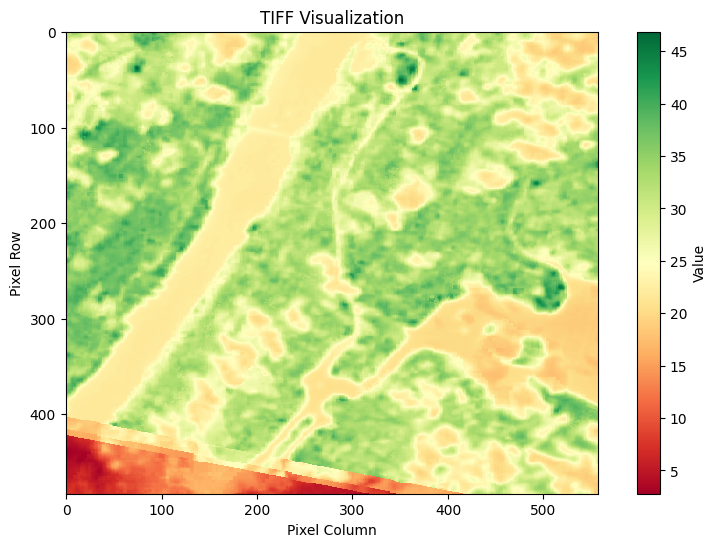

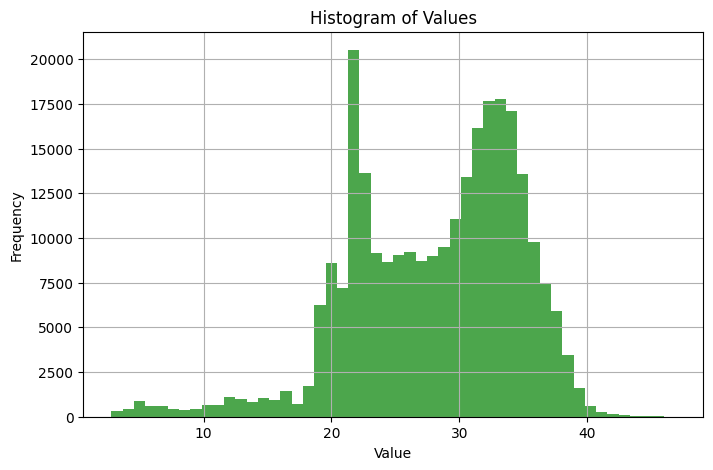

In [7]:
if SHOW_PLOTS:
    # Open the TIFF file
    with rasterio.open(lst_tiff_path) as src:
        # Print metadata
        print("Tiff Bounds:", src.bounds)
        print("CRS:", src.crs)
        print("Width, Height:", src.width, src.height)
        print("Number of bands:", src.count)
    
        # Read the first band (assuming it's a single-band raster or NDVI index)
        band1 = src.read(1)
    
    # Plot the raster data
    plt.figure(figsize=(10, 6))
    plt.imshow(band1, cmap='RdYlGn', interpolation='nearest')
    plt.colorbar(label="Value")
    plt.title("TIFF Visualization")
    plt.xlabel("Pixel Column")
    plt.ylabel("Pixel Row")
    plt.show()
    
    # Plot a histogram of NDVI values
    plt.figure(figsize=(8, 5))
    plt.hist(band1.flatten(), bins=50, color='green', alpha=0.7)
    plt.title("Histogram of Values")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()

Tiff Bounds: BoundingBox(left=-74.0100610851599, bottom=40.75, right=-73.85995328781891, top=40.8800754581387)
CRS: EPSG:4326
Width, Height: 1671 1448
Number of bands: 5


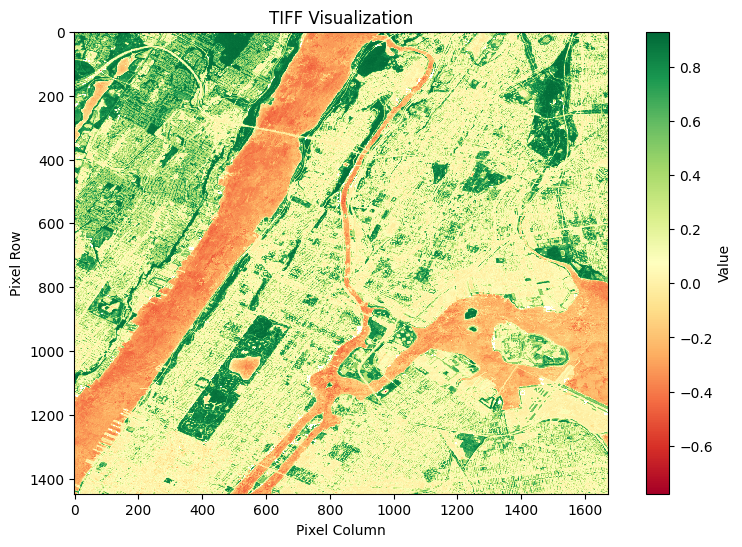

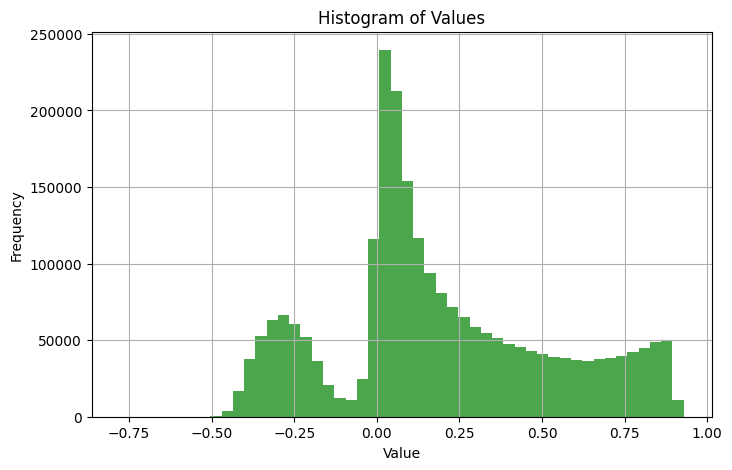

In [8]:
if SHOW_PLOTS:
    # Open the TIFF file
   
    with rasterio.open(indices_tiff_path) as src:
        # Print metadata
        print("Tiff Bounds:", src.bounds)
        print("CRS:", src.crs)
        print("Width, Height:", src.width, src.height)
        print("Number of bands:", src.count)
    
        # Read the first band (assuming it's a single-band raster or NDVI index)
        band1 = src.read(1)
    
    # Plot the raster data
    plt.figure(figsize=(10, 6))
    plt.imshow(band1, cmap='RdYlGn', interpolation='nearest')
    plt.colorbar(label="Value")
    plt.title("TIFF Visualization")
    plt.xlabel("Pixel Column")
    plt.ylabel("Pixel Row")
    plt.show()
    
    # Plot a histogram of NDVI values
    plt.figure(figsize=(8, 5))
    plt.hist(band1.flatten(), bins=50, color='green', alpha=0.7)
    plt.title("Histogram of Values")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()

### LOAD TRAINING DATA

In [9]:
print("Loading Training CSV ...")
df_train = pd.read_csv("./data/Training_data_uhi_index_UHI2025-v2.csv")
print("df_train shape:", df_train.shape)

gdf_train = gpd.GeoDataFrame(
    df_train,
    geometry=[Point(lon, lat) for lon, lat in zip(df_train["Longitude"], df_train["Latitude"])],
    crs="EPSG:4326"
).to_crs("EPSG:2263")

Loading Training CSV ...
df_train shape: (11229, 4)


In [10]:
import geopandas as gpd
from shapely.geometry import box

# 1. Extract the total bounds of gdf_train
minx_train, miny_train, maxx_train, maxy_train = gdf_train.total_bounds

# 2. Define a buffer in the same units as your CRS (here, meters)
buffer = 1500  # adjust this value if you need a slightly larger or smaller margin

# 3. Create an expanded bounding box
expanded_bbox = box(minx_train - buffer, 
                    miny_train - buffer, 
                    maxx_train + buffer, 
                    maxy_train + buffer)

# Optional: If you want to see the coordinates of the expanded bounding box:
print("Expanded Bounding Box:", expanded_bbox.bounds)

# 4. Create a sub-dataframe from gdf_buildings 1GB that only contains features intersecting the expanded bbox
gdf_buildings = gdf_buildings[gdf_buildings.geometry.intersects(expanded_bbox)]
gdf_buildings['centroid'] = gdf_buildings.geometry.centroid

# Check the total bounds of the new subset
print("Subset Total Bounds:", gdf_buildings.total_bounds)
print("Train Total Bounds:", gdf_train.total_bounds)

Expanded Bounding Box: (984285.411382811, 214227.52933294218, 1019120.8402454641, 253922.67726362712)
Subset Total Bounds: [ 983585.67815406  213867.61004415 1020550.32830597  254279.88059742]
Train Total Bounds: [ 985785.41138281  215727.52933294 1017620.84024546  252422.67726363]


In [11]:
# 1) Run DBSCAN
N_LARGEST = 8
eps_m = 450
min_samples = 40
gdf_buildings, cluster_centroids, top_clusters = run_dbscan_on_buildings(
    gdf_buildings, 
    eps_m=eps_m,
    min_samples=min_samples,
    N_LARGEST=N_LARGEST
)

print(f"Top {N_LARGEST} clusters by building count: {top_clusters}")
print("Cluster centroids for top N largest clusters:")
for (lbl, (cx, cy)) in cluster_centroids:
    print(f"  Cluster {lbl} => centroid=({cx:.2f}, {cy:.2f})")

Top 8 clusters by building count: [3 0 2 5 1 4 6 8]
Cluster centroids for top N largest clusters:
  Cluster 3 => centroid=(1009869.04, 218348.92)
  Cluster 0 => centroid=(996861.51, 229596.51)
  Cluster 2 => centroid=(1010270.59, 239017.05)
  Cluster 5 => centroid=(1012362.93, 249629.93)
  Cluster 1 => centroid=(987234.22, 216729.54)
  Cluster 4 => centroid=(1017870.67, 241201.63)
  Cluster 6 => centroid=(1004962.16, 244446.45)
  Cluster 8 => centroid=(1015300.93, 236268.83)


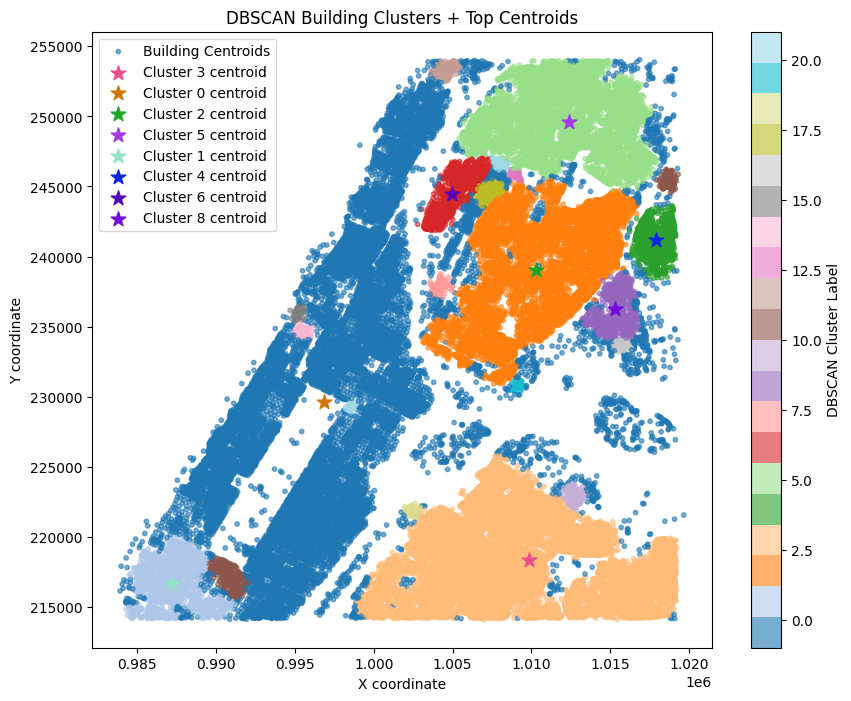

In [12]:
if SHOW_PLOTS:
    coords_bldg = np.column_stack([gdf_buildings["centroid"].x, gdf_buildings["centroid"].y])
    labels_bldg = gdf_buildings["bldg_cluster"].values
    
    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(
        coords_bldg[:, 0],
        coords_bldg[:, 1],
        c=labels_bldg,
        cmap='tab20',
        s=10,
        alpha=0.6,
        label="Building Centroids"
    )
    # Mark cluster centroids
    for (lbl, (cx, cy)) in cluster_centroids:
        random_color = mcolors.to_rgba((random.random(), random.random(), random.random()))
        ax.scatter(cx, cy, color=random_color, marker='*', s=120, label=f"Cluster {lbl} centroid")
    
    ax.set_title("DBSCAN Building Clusters + Top Centroids")
    ax.set_xlabel("X coordinate")
    ax.set_ylabel("Y coordinate")
    cb = plt.colorbar(scatter, ax=ax, label="DBSCAN Cluster Label")
    
    # Deduplicate legend entries
    handles, labels_ = ax.get_legend_handles_labels()
    by_label = dict(zip(labels_, handles))
    ax.legend(by_label.values(), by_label.keys(), loc="best")
    
    plt.show()

### BUILD TRAINING FEATURES

In [13]:
print("Building training features...")
features_dict_train = extract_features(gdf_train)

Building training features...
Extracting features for 11229 points...
  -> 0.00% done
  -> 4.45% done
  -> 8.91% done
  -> 13.36% done
  -> 17.81% done
  -> 22.26% done
  -> 26.72% done
  -> 31.17% done
  -> 35.62% done
  -> 40.07% done
  -> 44.53% done
  -> 48.98% done
  -> 53.43% done
  -> 57.89% done
  -> 62.34% done
  -> 66.79% done
  -> 71.24% done
  -> 75.70% done
  -> 80.15% done
  -> 84.60% done
  -> 89.06% done
  -> 93.51% done
  -> 97.96% done
100.00% done


### OUTLIER REMOVAL

In [14]:
print("Processing outliers...")
cap_quantile = 0.995
cap_val = gdf_train["UHI Index"].quantile(cap_quantile)
mask_out = (gdf_train["UHI Index"] > cap_val)
if mask_out.sum() > 0:
    print(f"Capping {mask_out.sum()} outliers above Q={cap_quantile} at {cap_val:.3f}")
    gdf_train.loc[mask_out, "UHI Index"] = cap_val

Processing outliers...
Capping 57 outliers above Q=0.995 at 1.041


### CREATE TRAINING DATAFRAME

In [15]:
# Add features to dataframe
for feat_key, feat_values in features_dict_train.items():
    gdf_train[feat_key] = feat_values

# Create interaction features
gdf_train = create_interaction_features(gdf_train)

# Prepare training data
feature_cols = [k for k, v in FEATURE_FLAGS.items() if v]
df_train_feat = gdf_train[feature_cols].copy()

# Handle categorical features
cat_col = "building_cluster_id"
if cat_col in df_train_feat.columns:
    df_train_feat[cat_col] = df_train_feat[cat_col].astype(str)
    train_dummies = pd.get_dummies(df_train_feat[cat_col], prefix=cat_col)
    df_train_feat = pd.concat([df_train_feat.drop(columns=[cat_col]), train_dummies], axis=1)

In [16]:
# Fill NA values with more intelligent strategies based on feature type
numeric_cols = df_train_feat.select_dtypes(include=np.number).columns
for col in numeric_cols:
    if df_train_feat[col].isna().any():
        # Use median for distance-based features (more robust than mean)
        if 'distance' in col or 'dist_' in col:
            df_train_feat[col] = df_train_feat[col].fillna(df_train_feat[col].median())
        else:
            # Use mean for other numeric features
            df_train_feat[col] = df_train_feat[col].fillna(df_train_feat[col].mean())

# Apply feature scaling for distance-based algorithms (especially important for KNN)
scaler = StandardScaler()
# Store column names to reconstruct dataframe after scaling
cols = df_train_feat.columns
# Scale features
X_scaled = scaler.fit_transform(df_train_feat.values)
# Reconstruct dataframe with scaled values
df_train_feat_scaled = pd.DataFrame(X_scaled, columns=cols)
# Get original features and target
X = df_train_feat.values
X_scaled = df_train_feat_scaled.values
y = gdf_train["UHI Index"].values
print("Final train feature shape:", X_scaled.shape)
print("Feature columns:", cols)

Final train feature shape: (11229, 27)
Feature columns: Index(['building_cov_250m', 'building_cov_500m', 'building_cov_750m', 'building_cov_std', 'distance_water', 'distance_water_exp', 'distance_parks', 'distance_parks_exp', 'street_tree_cov_250m', 'street_tree_cov_500m', 'street_tree_cov_750m', 'dist_to_closest_subway_station', 'dist_to_closest_subway_exp', 'dist_to_closest_cluster_centroid', 'lst_value', 'ndvi_value', 'ndbi_value', 'ndwi_value', 'evi_value', 'mndwi_value', 'building_cluster_id_N0', 'building_cluster_id_N1', 'building_cluster_id_N2', 'building_cluster_id_N4', 'building_cluster_id_N5', 'building_cluster_id_N6', 'building_cluster_id_N8'], dtype='object')


In [17]:
gdf_train["building_cluster_id"].unique()

array(['N2', 'N8', 'N0', 'N6', 'N1', 'N5', 'N4'], dtype=object)

In [18]:
gdf_train["building_cluster_id"].value_counts(dropna=False)

building_cluster_id
N0    4166
N2    2277
N6    1706
N8    1357
N1    1153
N5     529
N4      41
Name: count, dtype: int64

In [19]:
df_train_feat.describe(include='all')

,building_cov_250m,building_cov_500m,building_cov_750m,building_cov_std,distance_water,distance_water_exp,distance_parks,distance_parks_exp,street_tree_cov_250m,street_tree_cov_500m,street_tree_cov_750m,dist_to_closest_subway_station,dist_to_closest_subway_exp,dist_to_closest_cluster_centroid,lst_value,ndvi_value,ndbi_value,ndwi_value,evi_value,mndwi_value,building_cluster_id_N0,building_cluster_id_N1,building_cluster_id_N2,building_cluster_id_N4,building_cluster_id_N5,building_cluster_id_N6,building_cluster_id_N8
count,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229,11229,11229,11229,11229,11229,11229
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2,2,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7063,10076,8952,11188,10700,9523,9872
mean,0.312910,0.314795,0.308392,0.063199,1891.184531,0.120258,362.798049,0.582835,0.001620,0.001550,0.001516,1346.473005,0.281696,4637.339216,31.372035,0.209244,0.021330,-0.227787,1.708637,-0.254757,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.145414,0.119932,0.105806,0.037263,1298.246512,0.178100,360.343364,0.281969,0.000942,0.000785,0.000721,909.205876,0.208448,2293.168059,3.831732,0.202815,0.135185,0.172487,37.160787,0.123273,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,20.933619,0.000006,0.000000,0.018372,0.000000,0.000000,0.000000,7.600310,0.000530,89.216055,20.230583,-0.182557,-0.438507,-0.800440,-400.000000,-0.630162,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,0.222534,0.251169,0.255703,0.035136,930.568027,0.007986,76.262961,0.364074,0.000940,0.001008,0.001045,735.246718,0.115746,2876.150604,29.452401,0.057349,-0.052965,-0.311675,0.332226,-0.336400,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,0.332123,0.324589,0.312117,0.057776,1617.923389,0.039327,284.983308,0.565544,0.001627,0.001570,0.001539,1125.301971,0.244968,4378.439584,32.296193,0.135272,0.033894,-0.171683,0.841477,-0.247184,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,0.415632,0.397363,0.377266,0.087916,2415.031074,0.155496,505.198800,0.858537,0.002268,0.002091,0.002005,1725.086477,0.398894,6450.907795,34.070146,0.299983,0.110608,-0.098247,1.692870,-0.172586,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### DEFINE STRATIFIED CV

In [20]:
# Enhanced stratification for cross-validation
def make_stratified_bins(target, n_bins=10):
    bins = pd.qcut(target, q=n_bins, duplicates="drop")
    return bins.astype(str)

# Create stratified bins for cross-validation
K_FOLDS = 10
y_bins = make_stratified_bins(y, n_bins=10)

# Create spatial groups for spatial cross-validation
coords = np.column_stack([gdf_train.geometry.x, gdf_train.geometry.y])
kmeans = KMeans(n_clusters=K_FOLDS, random_state=RANDOM_SEED)
spatial_groups = kmeans.fit_predict(coords)

# Set up cross-validation strategies
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)
gkf = GroupKFold(n_splits=K_FOLDS)

In [21]:
# Detect and handle outliers
print("Detecting outliers...")
outlier_detector = OutlierDetector(contamination=0.01)
outlier_mask = outlier_detector.fit_detect(X, y)
print(f"Detected {sum(outlier_mask)} outliers out of {len(X)} samples")

Detecting outliers...
Detected 113 outliers out of 11229 samples


In [22]:
# Prepare non-outlier data for modeling
X_clean = X[~outlier_mask]
X_scaled_clean = X_scaled[~outlier_mask]
y_clean = y[~outlier_mask]
y_bins_clean = np.array(y_bins)[~outlier_mask]
spatial_groups_clean = spatial_groups[~outlier_mask]

### MODEL DEFINITIONS & HYPERPARAMETERS GRID

In [23]:
models_and_params = {
    "XGBoost": (
        xgb.XGBRegressor(random_state=RANDOM_SEED, use_label_encoder=False, eval_metric="rmse"),
        {
            "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
            "learning_rate": [0.005, 0.01, 0.03, 0.05, 0.1, 0.2],
            "max_depth": [6, 8, 10, 12, 15, 20, 23, 25, 30],
            "subsample": [0.7, 0.8, 0.9, 1.0],
            "colsample_bytree": [0.7, 0.8, 0.9, 1.0],
            # "min_child_weight": [1, 3, 5, 7],
            # "gamma": [0, 0.1, 0.2],
            # "reg_alpha": [0, 0.1, 0.5, 1.0],
            # "reg_lambda": [0.5, 1.0, 1.5],
        },
        400
    ),
    "CatBoost": (
        CatBoostRegressor(silent=True, random_state=RANDOM_SEED),
        {
            "iterations": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
            "max_depth": [5, 6, 7, 8, 9, 10, 11],
            "learning_rate": [0.005, 0.01, 0.03, 0.05, 0.1, 0.2],
            "random_strength": [1, 3, 5],
            "l2_leaf_reg": [1, 3, 5, 7, 9],
            "border_count": [32, 64, 128],
            "bagging_temperature": [0, 1, 10],
            
        },
        100
    ),
    "LightGBM": (
        lgb.LGBMRegressor(random_state=RANDOM_SEED, verbose=-1),
        {
            "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
            "max_depth": [10, 15, 20, 25, 30, 35, 40],
            "learning_rate": [0.005, 0.01, 0.03, 0.05, 0.1, 0.2],
            "subsample": [0.7, 0.8, 0.9, 1.0],
            "colsample_bytree": [0.7, 0.8, 0.9, 1.0],
            "num_leaves": [31, 63, 127, 255],
            # "reg_alpha": [0, 0.1, 0.5, 1.0],
            # "reg_lambda": [0, 0.1, 0.5, 1.0],
            "min_child_samples": [5, 10, 20, 50],
        },
        200
    ),
    "HistGradientBoosting": (
        HistGradientBoostingRegressor(random_state=RANDOM_SEED),
        {
            "max_iter": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
            "learning_rate": [0.005, 0.01, 0.03, 0.05, 0.1, 0.2],
            "max_depth": [10, 15, 20, 25, 30, 35, 40],
            "max_leaf_nodes": [31, 63, 127, 255],
            "l2_regularization": [0.0, 0.1, 0.5],
            "quantile": [0.1, 0.5, 0.8],
            "min_samples_leaf": [5, 10, 15],
        },
        200
    ),
    "DecisionTree": (
        DecisionTreeRegressor(random_state=RANDOM_SEED),
        {
            "splitter": ["best", "random"],
            "max_depth": [10, 15, 20, 25, 30, 35, 40],
            "min_samples_leaf": [1, 2, 3, 4],
        },
        200
    ),
    "RandomForest": (
        RandomForestRegressor(random_state=RANDOM_SEED),
        {
            "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
            "max_depth": [10, 15, 20, 25, 30, 35, 40],
            "min_samples_leaf": [1, 2, 3, 4],
            "min_samples_split": [2, 3, 4, 5],
            "max_features": [1.0, "sqrt", "log2", 0.5],
            # "bootstrap": [False],
            # "oob_score": [False],
        },
        200
    ),
    "ExtraTrees": (
        ExtraTreesRegressor(random_state=RANDOM_SEED),
        {
            "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
            "max_depth": [10, 15, 20, 25, 30, 35, 40, 45, 50],
            "min_samples_split": [2, 3, 4, 5],
            "min_samples_leaf": [1, 2, 3, 4],
            "max_features": [1.0, "sqrt", "log2", 0.5],
            # "ccp_alpha": [0.0, 0.001],
            # "bootstrap": [False],
            # "oob_score": [False],
        },
        500
    ),
    "KNeighbors": (
        KNeighborsRegressor(),
        {
            "n_neighbors": [1, 2, 3, 4, 5],
            "weights": ["uniform", "distance"],
            "p": [1, 2, 3, 4, 5],
            "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
            "leaf_size": [5, 10, 15, 20, 25, 30, 35, 40],
            "metric": ['minkowski', 'euclidean', 'manhattan', 'chebyshev'],
        },
        1000
    ),
        "RadiusNeighbors": (
        RadiusNeighborsRegressor(weights='distance'),
        {
            "radius": [50, 100, 150, 200, 300, 400, 500],
            "p": [1, 2, 3],
            "algorithm": ['auto', 'ball_tree', 'kd_tree'],
            "leaf_size": [5, 10, 15, 20, 25, 30],
            "metric": ['minkowski', 'euclidean', 'manhattan', 'chebyshev'],
        },
        1000
    ),
    "BayesianRidge": (
        BayesianRidge(),
        {
            "alpha_init": [1e-13, 1e-12, 1e-11, 1e-10, 1e-9],
            "lambda_init": [1e-13, 1e-12, 1e-11, 1e-10, 1e-9],
        },
        20
    ),
    "ElasticNet": (
        ElasticNet(random_state=RANDOM_SEED, max_iter=10000),
        {
            "alpha": [1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
            "l1_ratio": [0.01, 0.03, 0.05, 0.07, 0.1],
        },
        20
    ),
    # "NeuralNet": (
    #     MLPRegressor(random_state=RANDOM_SEED, max_iter=500),
    #     {
    #         "hidden_layer_sizes": [
    #             (64,), (128,), (64,64), (128,64),
    #         ],
    #         "activation": ["relu", "tanh"],
    #         "alpha": [1e-5, 1e-4, 1e-3],  # L2 reg
    #         "learning_rate_init": [0.001, 0.01],
    #         "solver": ["adam"],  # LBFGS is slower, sgd is less stable
    #     },
    #     10
    # ),
    # "SVR": (
    #     SVR(),
    #     {
    #         "kernel": ["rbf", "linear", "poly"],
    #         "C": [0.1, 1, 10],
    #         "epsilon": [0.01, 0.1, 0.5, 1.0],
    #         "gamma": ["scale"],
    #     },
    #     20
    # ),
    # "GPR": (
    #     GaussianProcessRegressor(random_state=RANDOM_SEED),
    #     {
    #         # We'll try a small kernel set
    #         "alpha": [1e-10, 1e-5, 1e-2],
    #         "kernel": [RBF(length_scale=1.0), Matern(length_scale=1.0, nu=1.5)],
    #     },
    #     2
    # ),
}

### RANDOM SEARCH FOR EACH MODEL

In [24]:
results = []
for model_name, (model, param_grid, n_iter) in models_and_params.items():
    print(f"\n=== Searching {model_name} ===")
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=n_iter,  # <--- use the model-specific n_iter
        cv=list(skf.split(X_scaled_clean, y_bins_clean)),
        scoring="r2",
        random_state=RANDOM_SEED,
        n_jobs=-1,
        verbose=3
    )
    search.fit(X, y)
    best_estimator = search.best_estimator_
    best_score = search.best_score_
    best_params = search.best_params_

    results.append({
        "Model": model_name,
        "Best Estimator": best_estimator,
        "Best Score (CV)": best_score,
        "Best Params": best_params
    })

results_df = pd.DataFrame(results).sort_values(by="Best Score (CV)", ascending=False)
print("\nFinal Cross-Val Results:\n", results_df)
results_df.to_csv("results_df_v21.csv", index=False, sep='|')


=== Searching XGBoost ===
Fitting 10 folds for each of 400 candidates, totalling 4000 fits

=== Searching CatBoost ===
Fitting 10 folds for each of 100 candidates, totalling 1000 fits

=== Searching LightGBM ===
Fitting 10 folds for each of 200 candidates, totalling 2000 fits

=== Searching HistGradientBoosting ===
Fitting 10 folds for each of 200 candidates, totalling 2000 fits

=== Searching DecisionTree ===
Fitting 10 folds for each of 56 candidates, totalling 560 fits

=== Searching RandomForest ===
Fitting 10 folds for each of 200 candidates, totalling 2000 fits

=== Searching ExtraTrees ===
Fitting 10 folds for each of 500 candidates, totalling 5000 fits

=== Searching KNeighbors ===
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits

=== Searching RadiusNeighbors ===
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits

=== Searching BayesianRidge ===
Fitting 10 folds for each of 20 candidates, totalling 200 fits

=== Searching ElasticNet ===
Fitti

In [25]:
results_df

,Model,Best Estimator,Best Score (CV),Best Params
7,KNeighbors,"KNeighborsRegressor(leaf_size=10, n_neighbors=...",0.975473,"{'weights': 'distance', 'p': 4, 'n_neighbors':..."
6,ExtraTrees,"(ExtraTreeRegressor(max_depth=35, random_state...",0.973951,"{'n_estimators': 1000, 'min_samples_split': 2,..."
0,XGBoost,"XGBRegressor(base_score=None, booster=None, ca...",0.965560,"{'subsample': 0.8, 'n_estimators': 900, 'max_d..."
2,LightGBM,"LGBMRegressor(colsample_bytree=0.7, learning_r...",0.964387,"{'subsample': 0.7, 'num_leaves': 255, 'n_estim..."
5,RandomForest,"(DecisionTreeRegressor(max_depth=25, max_featu...",0.960683,"{'n_estimators': 700, 'min_samples_split': 2, ..."
1,CatBoost,<catboost.core.CatBoostRegressor object at 0x0...,0.956548,"{'random_strength': 3, 'max_depth': 10, 'learn..."
3,HistGradientBoosting,"HistGradientBoostingRegressor(max_depth=30, ma...",0.950827,"{'quantile': 0.8, 'min_samples_leaf': 5, 'max_..."
4,DecisionTree,"DecisionTreeRegressor(max_depth=20, random_sta...",0.905499,"{'splitter': 'random', 'min_samples_leaf': 1, ..."
8,RadiusNeighbors,"RadiusNeighborsRegressor(algorithm='kd_tree', ...",0.792626,"{'radius': 500, 'p': 1, 'metric': 'euclidean',..."
9,BayesianRidge,"BayesianRidge(alpha_init=1e-09, lambda_init=1e...",0.369742,"{'lambda_init': 1e-13, 'alpha_init': 1e-09}"


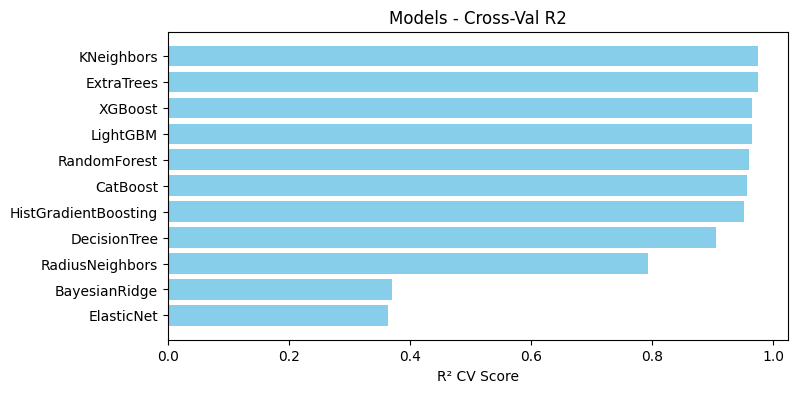

In [26]:
if SHOW_PLOTS:
    plt.figure(figsize=(8,4))
    plt.barh(results_df["Model"], results_df["Best Score (CV)"], color='skyblue')
    plt.gca().invert_yaxis()
    plt.xlabel("R² CV Score")
    plt.title("Models - Cross-Val R2")
    plt.show()

### VALIDATION DATA

In [27]:
print("Loading validation (submission) data...")
df_val = pd.read_csv("./data/Submission_template_UHI2025-v2.csv")

gdf_val = gpd.GeoDataFrame(
    df_val,
    geometry=[Point(lon, lat) for lon, lat in zip(df_val.Longitude, df_val.Latitude)],
    crs="EPSG:4326"
).to_crs("EPSG:2263")

Loading validation (submission) data...


### FEATURE ENGINEERING FOR VALIDATION SET

In [28]:
print("Building validation features...")
features_dict_val = extract_features(gdf_val)

Building validation features...
Extracting features for 1040 points...
  -> 0.00% done
  -> 48.08% done
  -> 96.15% done
100.00% done


In [29]:
# Add features to dataframe
for feat_key, feat_values in features_dict_val.items():
    gdf_val[feat_key] = feat_values

# Create interaction features
gdf_val = create_interaction_features(gdf_val)

# Prepare validation data
feature_cols = [k for k, v in FEATURE_FLAGS.items() if v]
df_val_feat = gdf_val[feature_cols].copy()

# Handle categorical features
cat_col = "building_cluster_id"
if cat_col in df_val_feat.columns:
    df_val_feat[cat_col] = df_val_feat[cat_col].astype(str)
    val_dummies = pd.get_dummies(df_val_feat[cat_col], prefix=cat_col)
    df_val_feat = pd.concat([df_val_feat.drop(columns=[cat_col]), val_dummies], axis=1)

In [31]:
# Fill NA values with more intelligent strategies based on feature type
numeric_cols = df_val_feat.select_dtypes(include=np.number).columns
for col in numeric_cols:
    if df_val_feat[col].isna().any():
        # Use median for distance-based features (more robust than mean)
        if 'distance' in col or 'dist_' in col:
            df_val_feat[col] = df_val_feat[col].fillna(df_val_feat[col].median())
        else:
            # Use mean for other numeric features
            df_val_feat[col] = df_val_feat[col].fillna(df_val_feat[col].mean())

# Apply feature scaling for distance-based algorithms (especially important for KNN)
scaler = StandardScaler()
# Store column names to reconstruct dataframe after scaling
cols = df_val_feat.columns
# Scale features
X_val_scaled = scaler.fit_transform(df_val_feat.values)
# Reconstruct dataframe with scaled values
df_val_feat_scaled = pd.DataFrame(X_val_scaled, columns=cols)
# Get original features and target
X_val = df_val_feat.values
X_val_scaled = df_val_feat_scaled.values
print("Final train feature shape:", X_val_scaled.shape)
print("Feature columns:", cols)

Final train feature shape: (1040, 27)
Feature columns: Index(['building_cov_250m', 'building_cov_500m', 'building_cov_750m', 'building_cov_std', 'distance_water', 'distance_water_exp', 'distance_parks', 'distance_parks_exp', 'street_tree_cov_250m', 'street_tree_cov_500m', 'street_tree_cov_750m', 'dist_to_closest_subway_station', 'dist_to_closest_subway_exp', 'dist_to_closest_cluster_centroid', 'lst_value', 'ndvi_value', 'ndbi_value', 'ndwi_value', 'evi_value', 'mndwi_value', 'building_cluster_id_N0', 'building_cluster_id_N1', 'building_cluster_id_N2', 'building_cluster_id_N4', 'building_cluster_id_N5', 'building_cluster_id_N6', 'building_cluster_id_N8'], dtype='object')


In [32]:
df_val_feat.describe(include='all')

,building_cov_250m,building_cov_500m,building_cov_750m,building_cov_std,distance_water,distance_water_exp,distance_parks,distance_parks_exp,street_tree_cov_250m,street_tree_cov_500m,street_tree_cov_750m,dist_to_closest_subway_station,dist_to_closest_subway_exp,dist_to_closest_cluster_centroid,lst_value,ndvi_value,ndbi_value,ndwi_value,evi_value,mndwi_value,building_cluster_id_N0,building_cluster_id_N1,building_cluster_id_N2,building_cluster_id_N4,building_cluster_id_N5,building_cluster_id_N6,building_cluster_id_N8
count,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040.000000,1040,1040,1040,1040,1040,1040,1040
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2,2,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,651,927,831,1034,1003,879,915
mean,0.316505,0.319223,0.313957,0.064382,1862.946328,0.121319,354.089910,0.587944,0.001659,0.001580,0.001550,1343.433165,0.285658,4583.646868,31.457096,0.210029,0.022228,-0.228936,3.075043,-0.257356,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.146398,0.122777,0.107044,0.037940,1291.951419,0.173940,352.246984,0.279155,0.000970,0.000805,0.000730,927.888462,0.214259,2302.881820,3.753276,0.207646,0.138768,0.176273,69.400691,0.126974,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,37.485593,0.000006,0.000000,0.018713,0.000000,0.000000,0.000000,14.814218,0.000569,97.441878,20.292107,-0.068966,-0.438507,-0.784428,-75.384613,-0.610677,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,0.223796,0.254554,0.261970,0.036742,924.712590,0.008326,74.049553,0.364194,0.000960,0.001006,0.001052,735.051227,0.113926,2876.118430,29.593394,0.057323,-0.051713,-0.307304,0.336740,-0.343701,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,0.340273,0.330494,0.314522,0.059652,1569.105207,0.043360,284.669629,0.565899,0.001664,0.001600,0.001578,1117.922503,0.247238,4226.282479,32.422660,0.132851,0.036437,-0.172663,0.790278,-0.245817,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,0.421988,0.401599,0.383261,0.086758,2394.165190,0.157328,505.034117,0.862347,0.002303,0.002139,0.002038,1737.766898,0.398993,6367.999952,34.064164,0.288634,0.115622,-0.099003,1.657083,-0.167603,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### ENSEMBLE: PICK TOP 3 MODELS

In [33]:
topN = results_df.head(3).reset_index(drop=True)
base_models = []
for i in range(len(topN)):
    mname = topN.loc[i, "Model"]
    mest = topN.loc[i, "Best Estimator"]
    base_models.append((mname, mest))

print("\nTop Models from CV:\n", base_models)

modelA, modelB, modelC = base_models[0][1], base_models[1][1], base_models[2][1]


Top Models from CV:
 [('KNeighbors', KNeighborsRegressor(leaf_size=10, n_neighbors=2, p=4, weights='distance')), ('ExtraTrees', ExtraTreesRegressor(max_depth=35, n_estimators=1000, random_state=42)), ('XGBoost', XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=25, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=900, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...))]


### WEIGHTED SEARCH

In [34]:
from sklearn.model_selection import KFold
def search_ensemble_weights_3(modelA, modelB, modelC, X, y, skf, increments=0.001):
    """
    Find best weights w1, w2, w3 that sum to 1
    for an ensemble of (modelA, modelB, modelC).
    Minimizes over entire data via out-of-fold approach.
    """
    predsA_oof = np.zeros(len(X))
    predsB_oof = np.zeros(len(X))
    predsC_oof = np.zeros(len(X))

    for train_idx, valid_idx in skf.split(X, y_bins):
        XA, XV = X[train_idx], X[valid_idx]
        ya, yv = y[train_idx], y[valid_idx]

        ma = clone(modelA).fit(XA, ya)
        mb = clone(modelB).fit(XA, ya)
        mc = clone(modelC).fit(XA, ya)

        predsA_oof[valid_idx] = ma.predict(XV)
        predsB_oof[valid_idx] = mb.predict(XV)
        predsC_oof[valid_idx] = mc.predict(XV)

    best_combo, best_r2 = (0,0,0), -999

    # Count total iterations
    num_steps = int(1 / increments) + 1
    total_iterations = (num_steps * (num_steps + 1)) // 2  # Sum of arithmetic series
    iteration_count = 0
    last_reported_progress = 0
    
    for w1 in np.arange(0,1+increments,increments):
        for w2 in np.arange(0,1+increments,increments):
            w3 = 1 - w1 - w2
            if w3 < 0:
                continue
            blend = w1*predsA_oof + w2*predsB_oof + w3*predsC_oof
            r2_ens = r2_score(y, blend)
            if r2_ens > best_r2:
                best_r2 = r2_ens
                best_combo = (w1, w2, w3)
            # Track progress
            iteration_count += 1
            progress = (iteration_count / total_iterations) * 100
            if round(progress) > last_reported_progress:
                last_reported_progress = round(progress)
                print(f"Progress: {last_reported_progress}%")
    return best_combo, best_r2

In [35]:
# Weighted 3-model ensemble with fine increments
best_combo, best_r2 = search_ensemble_weights_3(modelA, modelB, modelC, X, y, skf, increments=0.001)
w1, w2, w3 = best_combo
print(f"\nBest 3-model weights => w1={w1:.3f}, w2={w2:.3f}, w3={w3:.3f}; OOF R²={best_r2:.5f}")

# Refit all on full data
finalA = clone(modelA).fit(X, y)
finalB = clone(modelB).fit(X, y)
finalC = clone(modelC).fit(X, y)

predA_val = finalA.predict(X_val)
predB_val = finalB.predict(X_val)
predC_val = finalC.predict(X_val)

final_ensemble_val = w1*predA_val + w2*predB_val + w3*predC_val
df_val["UHI Index"] = final_ensemble_val

submission_3model_path = "output/submission_v21_3model_weighted.csv"
os.makedirs("output", exist_ok=True)
df_val[["Longitude", "Latitude", "UHI Index"]].to_csv(submission_3model_path, index=False)
print(f"Saved 3-model weighted ensemble submission => {submission_3model_path}")

Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Progress: 46%
Progress: 47%
Progress: 48%
Progress: 49%
Progress: 50%
Progress: 51%
Progress: 52%
Progress: 53%
Progress: 54%
Progress: 55%
Progress: 56%
Progress: 57%
Progress: 58%
Progress: 59%
Progress: 60%
Progress: 61%
Progress: 62%
Progress: 63%
Progress: 64%
Progress: 65%
Progress: 66%
Progress: 67%
Progress: 68%
Progress: 69%
Progress: 70%
Progress: 71%
Progress: 72%
P

### SAVE THE WEIGHTED ENSEMBLE

In [36]:
import pickle

ensemble_dict = {
    "model_names": [base_models[0][0], base_models[1][0], base_models[2][0]],
    "models": [finalA, finalB, finalC],
    "weights": (w1, w2, w3)
}
os.makedirs("models", exist_ok=True)
with open("models/3model_weighted_ensemble_v21.pkl","wb") as f:
    pickle.dump(ensemble_dict, f)
print("Saved 3-model weighted ensemble with discovered weights.")

Saved 3-model weighted ensemble with discovered weights.


### ENSEMBLE WITH SIMPLE AVERAGE

In [37]:
val_predsA = modelA.predict(X_val)
val_predsB = modelB.predict(X_val)
val_predsC = modelC.predict(X_val)

avg3 = (val_predsA + val_predsB + val_predsC) / 3
df_val["UHI Index"] = avg3
submission_avg3_path = "output/submission_v21-avg3.csv"
df_val[["Longitude","Latitude","UHI Index"]].to_csv(submission_avg3_path, index=False)
print(f"Saved simple average => {submission_avg3_path}")

avg2 = (val_predsA + val_predsB) / 2
df_val["UHI Index"] = avg2
submission_avg2_path = "output/submission_v21-avg2.csv"
df_val[["Longitude","Latitude","UHI Index"]].to_csv(submission_avg2_path, index=False)
print(f"Saved simple average => {submission_avg2_path}")

df_val["UHI Index"] = val_predsA
submission_top1_path = "output/submission_v21-1.csv"
df_val[["Longitude","Latitude","UHI Index"]].to_csv(submission_top1_path, index=False)
print(f"Saved simple average => {submission_top1_path}")

Saved simple average => output/submission_v21-avg3.csv
Saved simple average => output/submission_v21-avg2.csv
Saved simple average => output/submission_v21-1.csv


### META-LEARNERS

In [43]:
print("\nGenerating OOF predictions for meta-learner...")
oof_preds = np.zeros((len(X), len(base_models)))
for idx, (mname, base_model) in enumerate(base_models):
    print(f"  -> Base model {idx}: {mname}")
    model_clone = clone(base_model)
    for train_idx, valid_idx in skf.split(X, y_bins):
        X_trainF, X_validF = X[train_idx], X[valid_idx]
        y_trainF, y_validF = y[train_idx], y[valid_idx]
        model_clone.fit(X_trainF, y_trainF)
        oof_preds[valid_idx, idx] = model_clone.predict(X_validF)

from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingRegressor

meta_learners = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=RANDOM_SEED),
    "Lasso": Lasso(alpha=1e-5, random_state=RANDOM_SEED),
    "XGB": xgb.XGBRegressor(n_estimators=500, learning_rate=0.01,
                            max_depth=20, random_state=RANDOM_SEED,
                            subsample=0.8, colsample_bytree=0.8),
    "LightGBM": lgb.LGBMRegressor(n_estimators=500, learning_rate=0.01,
                                  num_leaves=63, max_depth=20, random_state=RANDOM_SEED),
    "RF": RandomForestRegressor(n_estimators=500, max_depth=20, random_state=RANDOM_SEED),
    "MLP": MLPRegressor(hidden_layer_sizes=(128,64), activation="relu",
                        solver="adam", max_iter=500, random_state=RANDOM_SEED)
}

scaler = StandardScaler()
X_oof_scaled = scaler.fit_transform(oof_preds)

meta_results = {}
for mname, meta_model in meta_learners.items():
    meta_model.fit(X_oof_scaled, y)
    preds_meta_oof = meta_model.predict(X_oof_scaled)
    r2_meta = r2_score(y, preds_meta_oof)
    meta_results[mname] = r2_meta

print("\n=== Meta-learner OOF R² comparison ===")
for mname, score_ in sorted(meta_results.items(), key=lambda x: x[1], reverse=True):
    print(f"{mname}: {score_:.5f}")

best_meta_name = max(meta_results, key=meta_results.get)
best_meta_model = meta_learners[best_meta_name]
print(f"\nBest meta-learner = {best_meta_name}, OOF R² => {meta_results[best_meta_name]:.5f}")

# Refit each base model on FULL data for final stack
base_models_fitted = []
full_preds_stack = np.zeros((len(X), len(base_models)))
for idx, (mname, base_model) in enumerate(base_models):
    fm = clone(base_model).fit(X, y)
    base_models_fitted.append((mname, fm))
    full_preds_stack[:, idx] = fm.predict(X)

# Refit meta-learner
full_preds_stack_scaled = scaler.transform(full_preds_stack)
final_meta_learner = clone(best_meta_model)
final_meta_learner.fit(full_preds_stack_scaled, y)
print("Refitted best meta-learner on entire dataset.")

# Validation predictions
val_stack = np.zeros((len(X_val), len(base_models_fitted)))
for idx, (mname, fm) in enumerate(base_models_fitted):
    val_stack[:, idx] = fm.predict(X_val)
val_stack_scaled = scaler.transform(val_stack)

final_val_preds_meta = final_meta_learner.predict(val_stack_scaled)
df_val["UHI Index"] = final_val_preds_meta

submission_meta_path = "output/submission_v21_meta.csv"
df_val[["Longitude","Latitude","UHI Index"]].to_csv(submission_meta_path, index=False)
print(f"Saved meta-learner submission => {submission_meta_path}")


Generating OOF predictions for meta-learner...
  -> Base model 0: KNeighbors
  -> Base model 1: ExtraTrees
  -> Base model 2: XGBoost

=== Meta-learner OOF R² comparison ===
XGB: 0.99123
LightGBM: 0.98146
Linear: 0.97832
Ridge: 0.97832
Lasso: 0.97829
MLP: 0.96726

Best meta-learner = XGB, OOF R² => 0.99123
Refitted best meta-learner on entire dataset.
Saved meta-learner submission => output/submission_v21_meta.csv


### TWEAK MODEL APPOACH

In [44]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Define your candidate tweak models (all with a low complexity to avoid overfitting the residuals)
tweak_models = {
    "DecisionTree": DecisionTreeRegressor(max_depth=8, random_state=RANDOM_SEED),
    "Ridge": Ridge(random_state=RANDOM_SEED),
    "LightGBM": lgb.LGBMRegressor(random_state=RANDOM_SEED, max_depth=8, n_estimators=100, learning_rate=0.01),
    "RandomForest": RandomForestRegressor(max_depth=8, random_state=RANDOM_SEED)
}

# We'll do a 3-model OOF to confirm final ensemble => then tweak
predsA_oof = np.zeros(len(X))
predsB_oof = np.zeros(len(X))
predsC_oof = np.zeros(len(X))

for train_idx, valid_idx in skf.split(X,y_bins):
    XA, XV = X[train_idx], X[valid_idx]
    ya, yv = y[train_idx], y[valid_idx]
    
    foldA = clone(modelA).fit(XA, ya)
    foldB = clone(modelB).fit(XA, ya)
    foldC = clone(modelC).fit(XA, ya)

    predsA_oof[valid_idx] = foldA.predict(XV)
    predsB_oof[valid_idx] = foldB.predict(XV)
    predsC_oof[valid_idx] = foldC.predict(XV)

# wA, wB, wC = (0.3,0.4,0.3)  # or from search_ensemble_weights_3
ensemble_oof = w1*predsA_oof + w2*predsB_oof + w3*predsC_oof
residual_oof = y - ensemble_oof

# Use regular KFold for continuous target (residuals)
cv_reg = KFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)

cv_scores = {}
for name, model in tweak_models.items():
    # Evaluate candidate tweak models using KFold on continuous residuals.
    scores = cross_val_score(model, X, residual_oof, cv=cv_reg, scoring="r2")
    cv_scores[name] = scores.mean()
    print(f"{name}: CV R² = {scores.mean():.4f}")

# Pick the tweak model with the best (highest) average R²
best_tweak_name = max(cv_scores, key=cv_scores.get)
best_tweak_model = tweak_models[best_tweak_name]
print(f"\nBest tweak model: {best_tweak_name} with CV R² = {cv_scores[best_tweak_name]:.4f}")

# Tweak model:
# tweak_model = DecisionTreeRegressor(max_depth=4).fit(X, residual_oof)

# Full-data refit
finalA = clone(modelA).fit(X,y)
finalB = clone(modelB).fit(X,y)
finalC = clone(modelC).fit(X,y)

predA_val = finalA.predict(X_val)
predB_val = finalB.predict(X_val)
predC_val = finalC.predict(X_val)

ensemble_val = w1*predA_val + w2*predB_val + w3*predC_val
best_tweak_model.fit(X, residual_oof)
residual_val = best_tweak_model.predict(X_val)
final_pred = ensemble_val + residual_val

df_val["UHI Index"] = final_pred
submission = df_val[["Longitude", "Latitude", "UHI Index"]]
submission_path = "output/submission_v21_tweak_3model-2.csv"
submission.to_csv(submission_path, index=False)
print(f"Saved {submission_path}")

DecisionTree: CV R² = -0.2526
Ridge: CV R² = -0.0042
LightGBM: CV R² = -0.1642
RandomForest: CV R² = -0.1805

Best tweak model: Ridge with CV R² = -0.0042
Saved output/submission_v21_tweak_3model-2.csv


### SAVE TOP MODELS

In [45]:
# Save each base model
os.makedirs("models", exist_ok=True)
for i, (mname, fm) in enumerate(base_models_fitted):
    output_path = f"models/base_{mname}_model_{i}_v21.pkl"
    dump(fm, output_path)
    print(f"Saved base model: {output_path}")

# Save final meta-learner
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
meta_output_path = f"models/final_meta_learner_{best_meta_name}_{timestamp}.pkl"
dump(final_meta_learner, meta_output_path)
print(f"Saved final meta-learner ({best_meta_name}) => {meta_output_path}")

Saved base model: models/base_KNeighbors_model_0_v21.pkl
Saved base model: models/base_ExtraTrees_model_1_v21.pkl
Saved base model: models/base_XGBoost_model_2_v21.pkl
Saved final meta-learner (XGB) => models/final_meta_learner_XGB_20250311_1832.pkl


### FEATURE EXPLORATION

In [46]:
final_feature_cols = list(df_train_feat.columns)
final_feature_cols

['building_cov_250m',
 'building_cov_500m',
 'building_cov_750m',
 'building_cov_std',
 'distance_water',
 'distance_water_exp',
 'distance_parks',
 'distance_parks_exp',
 'street_tree_cov_250m',
 'street_tree_cov_500m',
 'street_tree_cov_750m',
 'dist_to_closest_subway_station',
 'dist_to_closest_subway_exp',
 'dist_to_closest_cluster_centroid',
 'lst_value',
 'ndvi_value',
 'ndbi_value',
 'ndwi_value',
 'evi_value',
 'mndwi_value',
 'building_cluster_id_N0',
 'building_cluster_id_N1',
 'building_cluster_id_N2',
 'building_cluster_id_N4',
 'building_cluster_id_N5',
 'building_cluster_id_N6',
 'building_cluster_id_N8']

In [47]:
# Suppose 'results_df' is the DataFrame from your cross‑validation search.
# For illustration, we choose the best LightGBM model from results_df.
# (Alternatively, you can choose any tree‑based estimator that has a feature_importances_ attribute.)
best_model_row = results_df[results_df["Model"]=="ExtraTrees"].iloc[0]
best_model = best_model_row["Best Estimator"]

# Ensure that the training feature matrix X and the feature names are defined.
# (Here, final_feature_cols is your global list of feature names.)
print("Using best model from CV for feature importance probing.")
print("Final feature columns:", final_feature_cols)

# ----------------------------
# 1. Model-based Feature Importances
# ----------------------------
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    feat_imp_df = pd.DataFrame({
        'feature': final_feature_cols,
        'importance': importances
    }).sort_values(by='importance', ascending=False)
    print("\n=== Model-Based Feature Importances ===")
    print(feat_imp_df)
else:
    print("The chosen model does not have a feature_importances_ attribute.")

# ----------------------------
# 2. Permutation Importance (Model-Agnostic)
# ----------------------------
from sklearn.inspection import permutation_importance

print("\nComputing permutation importance...")
perm_result = permutation_importance(
    best_model, X, y, scoring='r2', n_repeats=10, random_state=RANDOM_SEED
)
perm_imp_df = pd.DataFrame({
    'feature': final_feature_cols,
    'importance_mean': perm_result.importances_mean,
    'importance_std': perm_result.importances_std
}).sort_values(by='importance_mean', ascending=False)
print("\n=== Permutation Feature Importances ===")
print(perm_imp_df)

Using best model from CV for feature importance probing.
Final feature columns: ['building_cov_250m', 'building_cov_500m', 'building_cov_750m', 'building_cov_std', 'distance_water', 'distance_water_exp', 'distance_parks', 'distance_parks_exp', 'street_tree_cov_250m', 'street_tree_cov_500m', 'street_tree_cov_750m', 'dist_to_closest_subway_station', 'dist_to_closest_subway_exp', 'dist_to_closest_cluster_centroid', 'lst_value', 'ndvi_value', 'ndbi_value', 'ndwi_value', 'evi_value', 'mndwi_value', 'building_cluster_id_N0', 'building_cluster_id_N1', 'building_cluster_id_N2', 'building_cluster_id_N4', 'building_cluster_id_N5', 'building_cluster_id_N6', 'building_cluster_id_N8']

=== Model-Based Feature Importances ===
                             feature  importance
22            building_cluster_id_N2    0.146913
13  dist_to_closest_cluster_centroid    0.118765
25            building_cluster_id_N6    0.075519
4                     distance_water    0.070514
10              street_tree_cov_7


Generating SHAP summary plot...


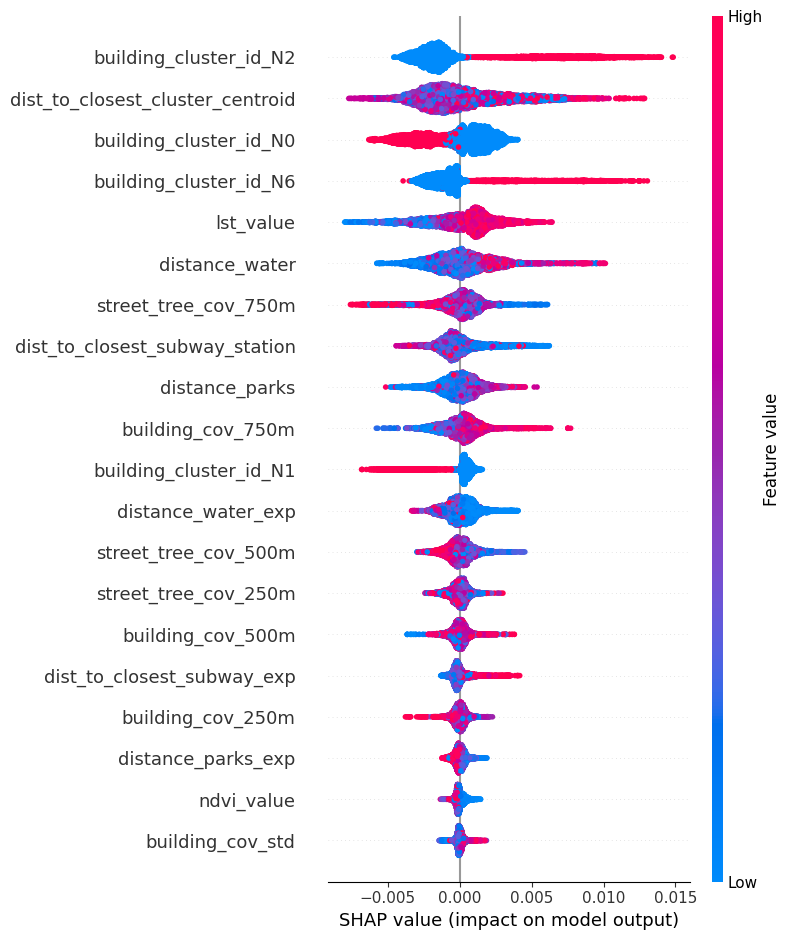


=== Mean Absolute SHAP Values ===
                             feature  mean_abs_shap
22            building_cluster_id_N2       0.002949
13  dist_to_closest_cluster_centroid       0.002276
20            building_cluster_id_N0       0.001840
25            building_cluster_id_N6       0.001771
14                         lst_value       0.001694
4                     distance_water       0.001518
10              street_tree_cov_750m       0.001055
11    dist_to_closest_subway_station       0.001031
6                     distance_parks       0.000936
2                  building_cov_750m       0.000922
21            building_cluster_id_N1       0.000792
5                 distance_water_exp       0.000744
9               street_tree_cov_500m       0.000661
8               street_tree_cov_250m       0.000436
1                  building_cov_500m       0.000418
12        dist_to_closest_subway_exp       0.000392
0                  building_cov_250m       0.000327
7                 distance_pa

In [48]:
# ----------------------------
# 3. SHAP Values (for detailed local/global explanations)
# ----------------------------
# Uncomment the block below if you wish to compute SHAP values.
# Note: SHAP can be computationally intensive.
best_model_row = results_df[results_df["Model"]=="XGBoost"].iloc[0]
best_model = best_model_row["Best Estimator"]
# Create a SHAP explainer for the model.
# For tree-based models, TreeExplainer is usually fast.
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X)

# Summary plot: This will produce an interactive (or static) plot of feature importance.
print("\nGenerating SHAP summary plot...")
if SHOW_PLOTS:
    shap.summary_plot(shap_values, X, feature_names=final_feature_cols)

# You can also compute mean absolute SHAP values:
shap_imp = np.abs(shap_values).mean(axis=0)
shap_imp_df = pd.DataFrame({
    'feature': final_feature_cols,
    'mean_abs_shap': shap_imp
}).sort_values(by='mean_abs_shap', ascending=False)
print("\n=== Mean Absolute SHAP Values ===")
print(shap_imp_df)